In [1]:
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
from math import gcd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import umap
from Modules import file_navigation
from Modules import rnaseqTools
from matplotlib.backends.backend_pdf import PdfPages

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5

color_dict = file_navigation.get_color_dict()

In [2]:
def get_lin_data():
    params = {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'Datasets/Lab_Pvalb-transcriptional_labels.tsv'
    df_labels = pd.read_csv(fname, na_values='Other', **params)
    df_labels = df_labels.loc[df_labels.Age>20,:]
    df_labels.sort_values('Age', inplace=True)
    
    fname = 'Datasets/Lab_Pvalb-tpm.tsv'
    df_tpm = np.log2(1+pd.read_csv(fname, **params))
    df_tpm = df_tpm.loc[:,df_labels.index].copy()
    
    arrays = [df_labels.index, df_labels['Morph-PV-types']]
    names = ('Cell', 'CellType')
    df_tpm.columns = pd.MultiIndex.from_arrays(arrays, names=names)
    
    return df_tpm.T, df_labels

def get_olm_data():
    params = {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'Datasets/Lab_OLM-labels.tsv'
    df_labels = pd.read_csv(fname, **params)
    
    fname = 'Datasets/Lab_OLM-tpm.tsv'
    df_tpm = pd.read_csv(fname, **params)
    df_tpm = df_tpm.loc[:,df_labels.CellType == 'SST-OLM']
    df_tpm = np.log2(1+df_tpm.T)
    
    arrays = [df_tpm.index, ['SST-OLM'] * df_tpm.shape[0]]
    names = ('Cell', 'CellType')
    df_tpm.index = pd.MultiIndex.from_arrays(arrays, names=names)
    
    return df_tpm

def get_harris_data():
    params= {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'Datasets/GSE99888-labels.tsv'
    df_labels = pd.read_csv(fname, **params)
    
    fname = 'Datasets/GSE99888-tpm.tsv'
    df = np.log2(1+pd.read_csv(fname, **params))
    
    arrays = [df_labels.index, df_labels.CellType]
    names = ('Cell', 'CellType')
    df.columns = pd.MultiIndex.from_arrays(arrays, names=names)
    
    return df.T

def get_pvalb_harris():
    df = get_harris_data()
    df = df.loc[df.index.get_level_values('CellType').str.startswith('Pvalb'),:].copy()
    
    return df

def get_cam_data(df_lin, df_olm, df_labels):
    df_new_labels = pd.DataFrame('', index=df_olm.index.get_level_values('Cell'), columns=df_labels.columns)
    for column in df_new_labels.columns:
        df_new_labels[column] = 'SST-OLM'
    
    df_labels = pd.concat((df_labels, df_new_labels),axis=0)
    df_cam = pd.concat((df_lin, df_olm),axis=0)
    
    fname = '/home/soma/Documents/Newest/analysisfiles/CAMmouse.txt'
    with open(fname) as f:
        cams = [line.split()[0] for line in f]
    df_cam = df_cam.loc[:,df_cam.columns.isin(cams)].copy()
    
    return df_cam, df_labels

def get_differential_gene_set(target, fdr=5):
    directory = 'Differential/edgeR/%s' % (target.split('-PV-types')[0])
    fnames = glob.glob('%s/*.txt' % directory)
    
    genes = []
    
    for fname in fnames:
        df = pd.read_csv(fname, sep='\t', header=0, index_col=0)
        df = df.loc[np.abs(df.logFC)>1]
        df_sig = df.loc[df.FDR<fdr/100]
        
        if df_sig.shape[0] > 0:
            genes.append(df_sig.index.tolist())
        
    return genes

def get_differential_genes(targets, fdr=5):
    gene_sets = [get_differential_gene_set(target, fdr=fdr) for target in targets]
    gene_set = [{gene for genes in gene_set for gene in genes} for gene_set in gene_sets]
    genes = sorted({gene for genes in gene_set for gene in genes})
    
    return genes

def get_gene_signifs(target):
    directory = 'Differential/edgeR/%s' % (target.split('-PV-types')[0])
    fnames = glob.glob('%s/*.txt' % directory)
    
    gene_datas = []
    for fname in fnames:
        df = pd.read_csv(fname, sep='\t', header=0, index_col=0)
        df = df.loc[np.abs(df.logFC)>1]
        gene_datas.append(df.FDR)
    
    gene_data = pd.concat(gene_datas, axis=1, sort=False)
    
    return gene_data.min(axis=1)

def get_signif_genes(targets, fdr=.05):
    gene_sets = pd.concat([get_gene_signifs(target) for target in targets], axis=1, sort=False)
    gene_signifs = gene_sets.min(axis=1).sort_values()
    
    gene_signifs = gene_signifs.loc[gene_signifs<=fdr]
    
    return gene_signifs

def calculate_embedding(datalist):
    reducer = umap.UMAP(n_components=2, n_neighbors=10, min_dist=.1, random_state=42, metric='euclidean')
    plotlist = reducer.fit_transform(datalist)
    
    return plotlist

def get_embeddings(df, gene_sets, cutoff=.05):
    fdrs = [5,10,15,20]
    columns = ['%d_%s' % (fdr, ending) for fdr in fdrs for ending in ('X', 'Y')]
    df_embed = pd.DataFrame(np.NaN, index=df.index, columns=columns)
    
    for num, fdr in enumerate(fdrs):
        genes = get_differential_genes(gene_sets, fdr=fdr)
        df_data = df.loc[:,genes]
        df_data = df_data.loc[:,(df_data.values>0).mean(axis=0)>cutoff]
        plotlist = calculate_embedding(df_data.values)
        df_embed.iloc[:,[num*2,num*2+1]] = plotlist
    
    return df_embed

def map_to_data(df_target, df_base, df_embed, n=10):
    kept = (df_base>0).sum(axis=1)>2
    df_base = df_base.loc[kept,:]
    df_embed = df_embed.loc[kept,:]
    
    correlations = rnaseqTools.corr2(df_target.values, df_base.values)
    inds = correlations.argsort(axis=1)[:,-n:]
    df_map = pd.DataFrame(np.NaN, index=df_target.index, columns=df_embed.columns)
    for column, embed_dim in df_embed.iteritems():
        data = embed_dim.values
        df_map.loc[:,column] = np.median(data[inds], axis=1)
    
    return df_map

def get_mappings(df_target, df_base, df_embed, gene_sets, n=10, cutoff=0.05, is_genes=False):
    fdrs = [5,10,15,20]
    columns = ['%d_%s' % (fdr, ending) for fdr in fdrs for ending in ('X', 'Y')]
    df_map = pd.DataFrame(np.NaN, index=df_target.index, columns=columns)
    
    for fdr in fdrs:
        if is_genes:
            genes = gene_sets
        else:
            genes = get_differential_genes(gene_sets, fdr=fdr)
        df_sub_base = df_base.loc[:,genes]
        df_sub_base = df_sub_base.loc[:,(df_sub_base.values>0).mean(axis=0)>cutoff]
        df_sub_target = df_target.loc[:,df_sub_base.columns]
        columns = ['%d_X' % fdr, '%d_Y' % fdr]
        df_map.loc[:,columns] = map_to_data(df_sub_target, df_sub_base, df_embed.loc[:,columns], n=n)
    
    return df_map

def get_dimension_adjustments(df_lin, df_pvalb, df_embed, gene_sets, n=10):
    df_embed = get_embeddings(df_pvalb, gene_sets)
    df_map = get_mappings(df_lin, df_pvalb, df_embed, gene_sets, n=10)
    
    return df_embed, df_map

def plot_data(df_embed, df_map, color_dict, figname):
    harris_colors = df_embed.index.get_level_values('CellType').map(color_dict).values
    lin_colors = df_lin.index.get_level_values('CellType').map(color_dict).values
    fig = plt.figure(figsize=(8.5,11))

    for i in range(0,df_embed.shape[1],2):
        plotlist = df_embed.iloc[:,i:i+2].values
        maplist = df_map.iloc[:,i:i+2].values
        fdr = df_embed.columns[i][:-2]

        col = (i//2) % 2
        row = (i//2) // 2
        ax = fig.add_axes([.14+.4*col, .6 - .3*row, .33, .255])
        ax.set_title('FDR = %s%%' % fdr, fontsize=12)
        ax.set_xticks([]), ax.set_yticks([])
        ax.scatter(plotlist[:,0], plotlist[:,1], color=harris_colors, s=8, zorder=0)
        ax.scatter(maplist[:,0], maplist[:,1], facecolor=lin_colors, edgecolor='#000000', s=32, zorder=1, linewidth=1)

    fig.savefig('Figures/%s.pdf' % figname)
    plt.show()
    plt.close()
    
    return

def add_labels_csaba(df, df_labels):
    is_bottom = np.logical_and(df.X>-2, df.Y<0)
    is_right = np.logical_and(df.X>-2.1, df.Y>0)
    is_center = np.logical_and(df.X>-3.6, ~np.logical_or(is_right, is_bottom))
    is_left = ~np.logical_or(is_bottom, np.logical_or(is_right, is_center))
    df_labels.loc[is_bottom.values,'Csaba'] = 'Group1'
    df_labels.loc[is_right.values,'Csaba'] = 'Group2'
    df_labels.loc[is_center.values,'Csaba'] = 'Group3'
    df_labels.loc[is_left.values,'Csaba'] = 'Group4'
    
    return

def add_labels_soma(df, df_labels):
    is_left = np.logical_and(df.X<-3, df.Y>(.2*df.X+2.9))
    is_right = np.logical_and(df.X>-2.5,df.Y>1.55)
    is_bottom = np.logical_and(df.X>-1,df.Y<1.55)
    is_center = np.logical_and(df.X<-1, df.Y<1.55)
    df_labels.loc[is_bottom.values,'Soma'] = 'Group1'
    df_labels.loc[is_right.values,'Soma'] = 'Group2'
    df_labels.loc[is_center.values,'Soma'] = 'Group3'
    df_labels.loc[is_left.values,'Soma'] = 'Group4'
    
    return

def get_classifications(df):
    index = df.index.get_level_values('Cell')
    columns = ['CellType', 'Csaba', 'Soma']
    df_labels = pd.DataFrame('', index=index, columns=columns)
    
    df_labels.CellType = df.index.get_level_values('CellType')
    add_labels_csaba(df, df_labels)
    add_labels_soma(df, df_labels)
    
    return df_labels

def get_lcm(*args):
    """
    get lowest common multiple of a series of numbers, and what they need to be multiplied by
    to get that large
    """
    lcm = 1
    for number in args:
        lcm = (lcm * number) // gcd(lcm, number)
    
    multiples = [lcm // number for number in args]
    
    return lcm, multiples
    

def get_sorted_order(df_tpm, labels):
    """
    hierarchically sort a dataframe
    despite different cell types having different number of cells, we want to weigh them evenly
    """
    
    # get lowest common multiple, and how much cells need to be multiplied by
    counts = labels.value_counts()
    lcm, multiple = get_lcm(*counts)
    
    # construct artifically inflated dataset
    datalist = df_tpm.values.T
    datalists = []
    for label, mult in zip(counts.index, multiple):
        data = datalist[:,labels==label]
        datalists.append(np.tile(data, mult))
    datalist = np.hstack(datalists)
    
    # do hierarchical sorting
    Z = linkage(datalist, method='average', metric='euclidean')
    D = dendrogram(Z, no_plot=True)
    index = D['leaves']
    
    df_tpm = df_tpm.iloc[:,index]
    
    return df_tpm

def do_heatmap(fig, axrange, df_tpm, labels, tick_size=6, order=['AAC', 'vBIC', 'hBIC', 'vBC', 'hBC', 'SST-OLM']):
    # get data of interest
    if len(order) == 0:
        order = sorted(set(labels.tolist()))
    high = df_tpm.values.max()*1.01
    
    # sort genes
    df_tpm = get_sorted_order(df_tpm, labels)
    df_tpm = df_tpm.T
    
    # calculate target sizes
    Left, Bottom, Width, Height = axrange
    dW = .0022
    W = (Width - dW*(len(order)-1)) / df_tpm.shape[1]
    left = Left
    
    # plot data
    for col, celltype in enumerate(order):
        # get parameters for each column
        df_celltype = df_tpm.loc[:,(labels==celltype).values]
        width = W * df_celltype.shape[1]
        
        # generate axes
        ax = fig.add_axes([left, Bottom, width, Height])
        ax.set_title(celltype, fontsize=5)
        if col != 0 and False:
            ax.spines['left'].set_visible(False)
        if col != len(order)-1 and False:
            ax.spines['right'].set_visible(False)
        ax.set_xticks([]), ax.set_yticks([])
        
        # do plot
        pcol = ax.pcolor(df_celltype.values, vmin=0, vmax=high, cmap=mpl.cm.Reds)
        pcol.set_edgecolor('face')
        ax.axis([0,df_celltype.shape[1], 0, df_celltype.shape[0]])
        
        left += width + dW
    
    cax = fig.add_axes([Left, Bottom-.02, Width, .01])
    plt.colorbar(pcol, cax=cax, orientation='horizontal')
    cax.tick_params(size=1, labelsize=5, pad=1)
    
    return

def order_similarity_matrix(df_sim):
    indices = df_sim.columns
    if 'Continent 2' in indices:
        order = ['Continent 2', 'Continent 3' ,'SST-OLM']
    elif 'Map6d1.Axin1' in indices:
        order = ['Map6d1.Axin1', 'Map6d1.Tmem205', 'P2ry12.Bcl2a1b', 'P2ry12.Fam110b', 'SST-OLM']
    elif 'BIC' in indices:
        order = ['AAC', 'BIC', 'BC', 'SST-OLM']
    elif 'hBIC' in indices:
        order = ['AAC', 'vBIC', 'hBIC', 'vBC', 'hBC', 'SST-OLM']
    else:
        order = ['Vertical', 'Horizontal', 'SST-OLM']
    
    df_sim = df_sim.loc[order, order]
    return df_sim

def get_similarity_matrix(df, labels):
    datalist = df.values
    corr = rnaseqTools.corr2(datalist, datalist)
    df_sim = pd.DataFrame(corr, index=labels, columns=labels)
    
    inds = np.arange(df_sim.shape[0])
    df_sim.values[inds,inds] = np.NaN
    
    df_sim = df_sim.groupby(df_sim.index).mean().groupby(df_sim.columns,axis=1).mean()
    df_sim = order_similarity_matrix(df_sim)
    
    return df_sim

def create_merge_data(df_pvalb, gene_signifs, df_embed):
    df_pvalb = df_pvalb.loc[:,gene_signifs.index].copy()
    df_merge = pd.concat((df_embed, df_pvalb), axis=1)
    df_celltype = pd.DataFrame(df_merge.index.get_level_values('CellType'),
                               index=df_merge.index.get_level_values('Cell'),
                               columns=['CellType'])
    
    df_merge.index = df_celltype.index
    df_merge = pd.concat((df_celltype, df_merge), axis=1)
    df_fdr = pd.DataFrame([['', np.NaN, np.NaN] + gene_signifs.tolist()], index=['FDR'], columns=df_merge.columns)
    df_fdr.index.name = 'Cell'
    df_merge = pd.concat((df_fdr, df_merge), axis=0)
    

    return df_merge

In [3]:
%%time

# read in data

gene_sets = ['Morph', 'MorphMarker', 'MorphDirectional']
gene_signifs = get_signif_genes(gene_sets, fdr=.15)
df_pvalb = get_pvalb_harris()
df_lin, df_labels = get_lin_data()
df_olm = get_olm_data()
df_cam, df_labels = get_cam_data(df_lin, df_olm, df_labels)
df_cam = df_cam.loc[:,(df_cam.values>1).sum(axis=0)>2]
df_embed = pd.read_csv('Mapping/DifferentialMapping/Harris.tsv', sep='\t', header=0, index_col=[0,1])
df_merge = create_merge_data(df_pvalb, gene_signifs, df_embed)
df_merge.to_csv('Mapping/DifferentialMapping/Mapping Significants.tsv', sep='\t')

CPU times: user 40.1 s, sys: 978 ms, total: 41.1 s
Wall time: 41.1 s


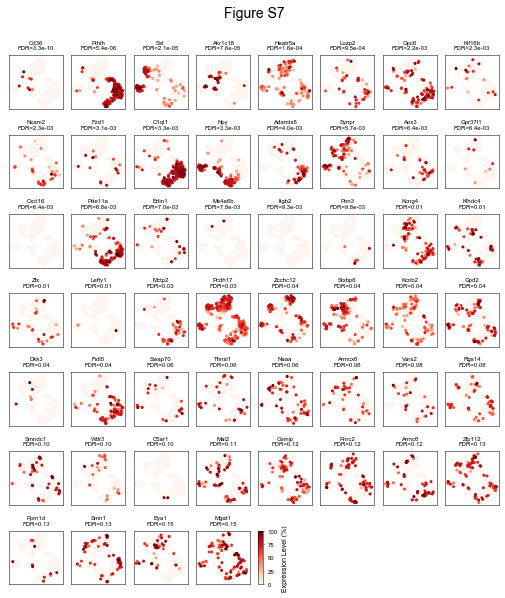

CPU times: user 7.11 s, sys: 1.39 s, total: 8.49 s
Wall time: 5.82 s


In [4]:
%%time

fig = plt.figure(figsize=(8.5,11))

pp = PdfPages('Figures/Figure S7.pdf')
fig.suptitle('Figure S7', y=.93, fontsize=14)

plotlist = df_embed.values
ncol = 8

for axnum, (gene, signif) in enumerate(gene_signifs.iteritems()):
    row = axnum // ncol
    col = axnum % ncol
    width = .088
    height = width / 11 * 8.5
    dw = width + (.8 - width*ncol) / (ncol-1)
    dh = .8 / 8
    bottom = .9 - dh
    ax = fig.add_axes([.1+dw*col, bottom-dh*row, .088, .068])
    ax.set_xticks([]), ax.set_yticks([])
    
    values = df_pvalb.loc[:,gene].values
    text = '%s\nFDR=%.1e' if signif < .01 else '%s\nFDR=%.2f'
    ax.set_title(text % (gene, signif), fontsize=6, y=1)
    values = values / max(values.max(), 1e-3)
    color = mpl.cm.Reds(values)
    
    idx = values.argsort()
    
    ax.scatter(plotlist[idx,0], plotlist[idx,1], color=color[idx], s=4)
    
cax = fig.add_axes([.1+dw*(col+1), bottom-dh*row, .008, .068])
cmap = mpl.cm.Reds
norm = mpl.colors.Normalize(vmin=0, vmax=100)

cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                orientation='vertical')
cb1.set_label('Expression Level (%)', fontsize=7)
cb1.ax.tick_params(size=1, labelsize=6)

fig.savefig('Figures/Figure S7.pdf')
plt.show()
plt.close()